In [1]:
import xarray as xr
import rioxarray as rio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.features import rasterize


### Import boundaries for spatial distribution

In [2]:
# Read the shapefile
shapefile_path = '//gmvstorage.gmv.es/storage/anin/Groundwater/2011 Freshwater Ecosystem Priority Areas 9 Water Management Areas/9WMA.shp'
areas = gpd.read_file(shapefile_path)
areas = areas.set_crs('EPSG:4326')

# Field in the shapefile table of attributes to be used for the averaging of the SGI and SSFI indices
grouping_field = 'WMA_NewID' # Numeric grouping field for shapefile rasterization
averaging_field ='WMA_NewN' # String grouping field for averaging of the SGI and SSFI indices and plotting

#### Read SPEI and SPI

In [3]:
fN_spei = "//gmvstorage.gmv.es/storage/anin/SPEI/outputs/SPEI3.nc"
fN_spi= "//gmvstorage.gmv.es/storage/anin/SPI/outputs/SPI.nc"

spei = xr.open_dataset(fN_spei)
spi = xr.open_dataset(fN_spi)

# Select time range matching the available GWL observations.
start_date_spi = "1999-10-01"
start_date_spei = "1999-09-01"
end_date = "2022-07-01"

spei = spei.sel(time=slice(start_date_spei,end_date))
spei= spei.rio.write_crs(4326, inplace=True)
spei = spei.rename({'__xarray_dataarray_variable__': 'spei'})

spi = spi.sel(time=slice(start_date_spi, end_date))
spi = spi.rio.write_crs(4326, inplace=True)
spi = spi.rename({'__xarray_dataarray_variable__': 'spi'})

#### Rasterize the shapefile to be able to perform zonal statistics over rasterized data (ERA5)

In [4]:

shapes = ((geom, value) for geom, value in zip(areas.geometry, areas[grouping_field])) # Shapefile field must be numerical for this to work

eco_regions = rasterize(
    shapes=shapes,
    out_shape=(len(spi.y.data), len(spi.x.data)),
    transform=spi.rio.transform(),
    default_value=0,
)

#### Compute Zonal Statistics

In [5]:
eco_spi = {}
eco_spei= {}

for id_basin in areas[grouping_field]:

    spi_aux = spi.spi.data[:, eco_regions==id_basin]
    spi_mean = np.nanmean(spi_aux,axis=1)
    eco_spi.update({areas[averaging_field][areas[grouping_field]==id_basin].values[0]: spi_mean})

    spei_aux = spei.spei.data[:, eco_regions==id_basin]
    spei_mean = np.nanmean(spei_aux,axis=1)
    eco_spei.update({areas[averaging_field][areas[grouping_field]==id_basin].values[0]: spei_mean})


In [6]:
df_spi = pd.DataFrame.from_dict(eco_spi).T
df_spei = pd.DataFrame.from_dict(eco_spei).T

### Compute the SGI and SSFI for all the stations

In [7]:
# Import the modiefied SGI and SSFI function which includes scaling 
from comparison_tools import compute_sgi
from comparison_tools import compute_ssfi
from comparison_tools import average_index

# Define  index scaling factor
scale = 3

### Groundwater

##### Import GWL stations data

In [8]:
# Load Metadata 
metadata_path = "//gmvstorage.gmv.es/storage/anin/Groundwater/processed_data/stations_metadadata22_active.xlsx"
meta_df = pd.read_excel(metadata_path)
meta_df.set_index('Station',inplace=True)

# Select the columns that are necessary for this code
meta_df = meta_df.iloc[:, 0:2]

# Load data
df_path = "//gmvstorage.gmv.es/storage/anin/Groundwater/processed_data/stations_data22_active.xlsx"
df = pd.read_excel(df_path)
df = df.iloc[:,1:]
df.set_index('date',inplace=True)

# Create a pandas time series for the plot function to work
dates = pd.to_datetime(df.index)

##### Compute SGI for all stations 

In [9]:
# Create a new DataFrame to store the SGI values
df_sgi = pd.DataFrame()

# Apply the SGI function to each column of the DataFrame

for column in df.columns:
    df_sgi[column] = compute_sgi(df[column],scale)

# Reset the index & Transpose the DataFrame
dates = df_sgi.index.to_pydatetime()
df_sgi = df_sgi.reset_index(drop = True)
df_sgi = df_sgi.T

C:\Users\ecig\AppData\Local\Temp\ipykernel_22224\1915096157.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_sgi[column] = compute_sgi(df[column],scale)
C:\Users\ecig\AppData\Local\Temp\ipykernel_22224\1915096157.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_sgi[column] = compute_sgi(df[column],scale)
C:\Users\ecig\AppData\Local\Temp\ipykernel_22224\1915096157.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

##### Perform the average of the SGI values for thea areas defined by the shapefile

In [10]:
# Join with coordinate information in metadata dataframe
df_latlon = df_sgi.join(meta_df)

# Average SGI using the areas shapefile
sgi_averages = average_index(df_latlon,areas,averaging_field)

c:\Users\ecig\Anaconda3\envs\geoTools\lib\site-packages\IPython\core\interactiveshell.py:3433: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\ecig\Documents\Python Scripts\anin_git\drought-indices\IndexComparison\comparison_tools.py:108: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  stations_by_polygon = gpd.sjoin(shapefile, stations_gdf, how='inner', op='contains')


### Streamflow

##### Import Q stations data

In [22]:
streamflow_data = "//gmvstorage.gmv.es/storage/anin/Streamflow/processed_data/clean_streamflow.xlsx"
df_streamflow = pd.read_excel(streamflow_data, index_col=0)

# Crop the streamflow data according to the dates availability to make it match with the other indices
df_streamflow = df_streamflow[start_date_spei : end_date]

metadata = "//gmvstorage.gmv.es/storage/anin/Streamflow/processed_data/clean_metadata.xlsx"
df_metadata = pd.read_excel(metadata, index_col=0)

# Simplify the metadata to just keep the station names and geographical coordinates

df_metadata = df_metadata.set_index('STATION')[['LONGITUDE', 'LATITUDE']]
df_metadata.rename(columns={"LONGITUDE": "Longitude", "LATITUDE": "Latitude"},inplace=True,)


##### Compute SSFI for all the stations

In [24]:
# Create a new DataFrame to store the SSFI values
df_ssfi = pd.DataFrame()

# Apply the SSFI function to each column of the DataFrame

for column in df_streamflow.columns:
    df_ssfi[column] = compute_ssfi(df_streamflow[column],scale)

# Reset the index & Transpose the DataFrame
dates = df_ssfi.index.to_pydatetime()
df_ssfi = df_ssfi.reset_index(drop = True)
df_ssfi = df_ssfi.T

C:\Users\ecig\AppData\Local\Temp\ipykernel_22224\755555506.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ssfi[column] = compute_ssfi(df_streamflow[column],scale)
C:\Users\ecig\AppData\Local\Temp\ipykernel_22224\755555506.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ssfi[column] = compute_ssfi(df_streamflow[column],scale)
C:\Users\ecig\AppData\Local\Temp\ipykernel_22224\755555506.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

##### Perform the average of the SGI values for thea areas defined by the shapefile

In [25]:
# Join with coordinate information in metadata dataframe
df_latlon2 = df_ssfi.join(df_metadata)

# Average SGI using the areas shapefile
ssfi_averages = average_index(df_latlon2,areas,averaging_field)

c:\Users\ecig\Anaconda3\envs\geoTools\lib\site-packages\IPython\core\interactiveshell.py:3433: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\ecig\Documents\Python Scripts\anin_git\drought-indices\IndexComparison\comparison_tools.py:108: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  stations_by_polygon = gpd.sjoin(shapefile, stations_gdf, how='inner', op='contains')


#### Plot the resulting time series by area

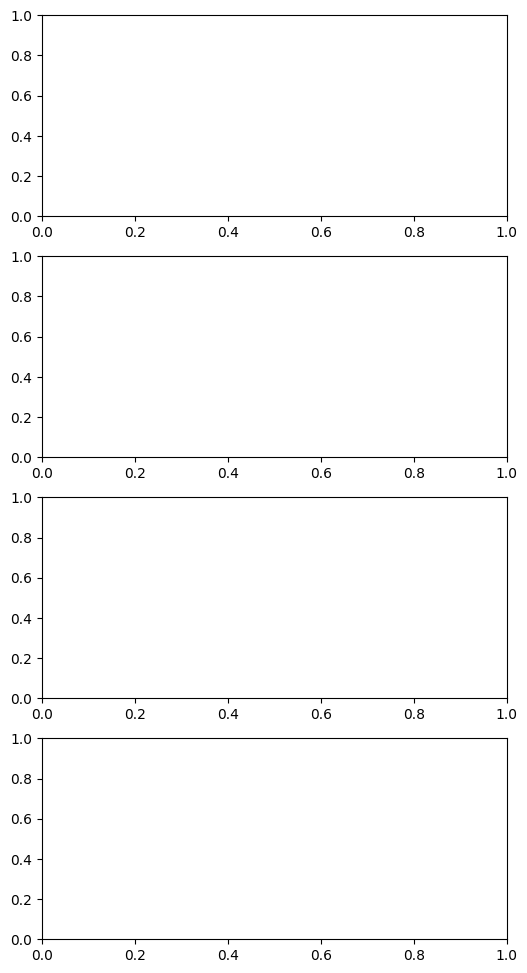

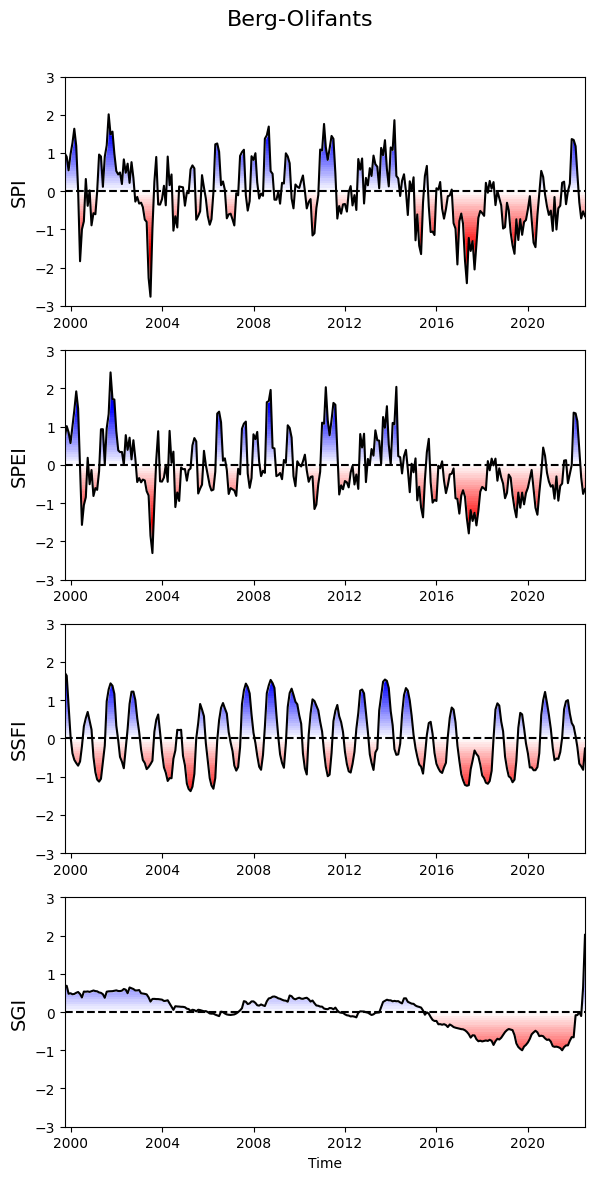

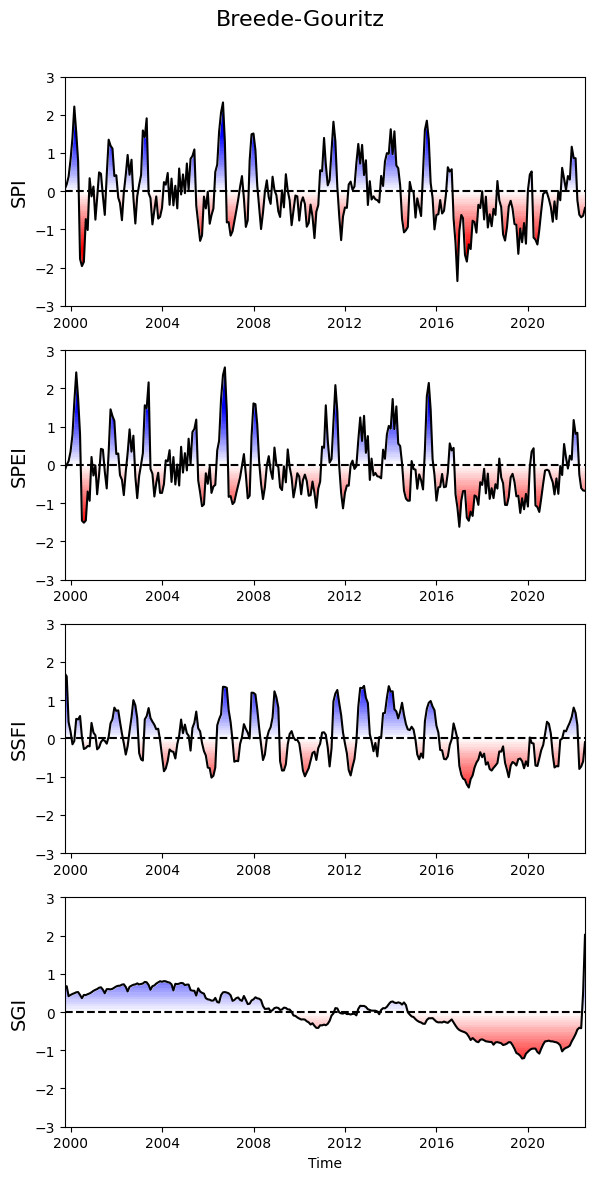

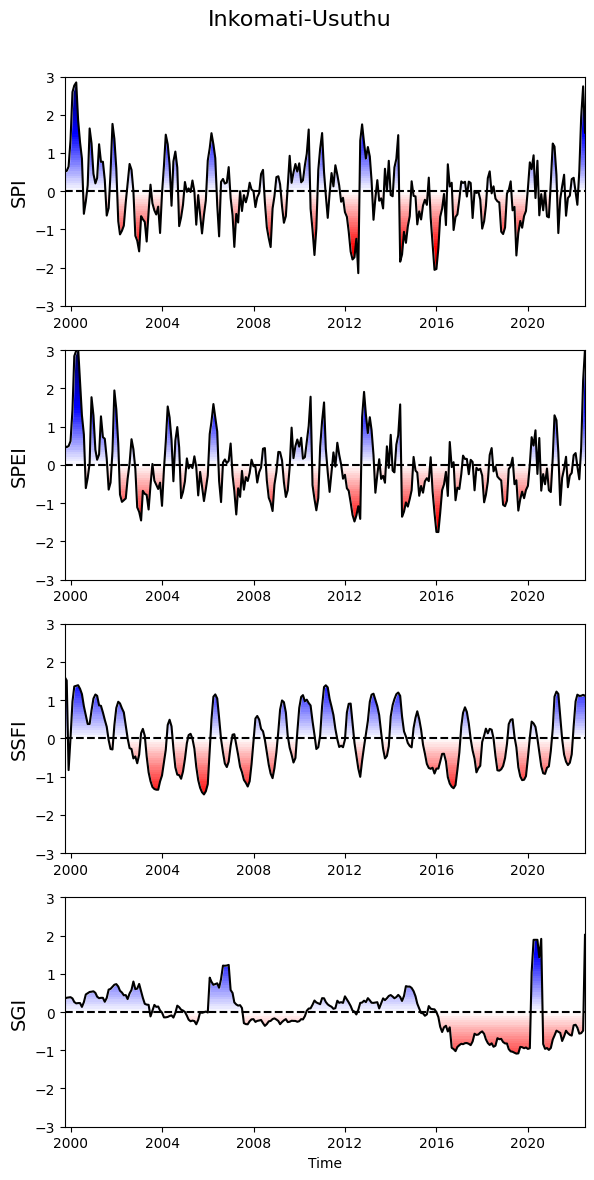

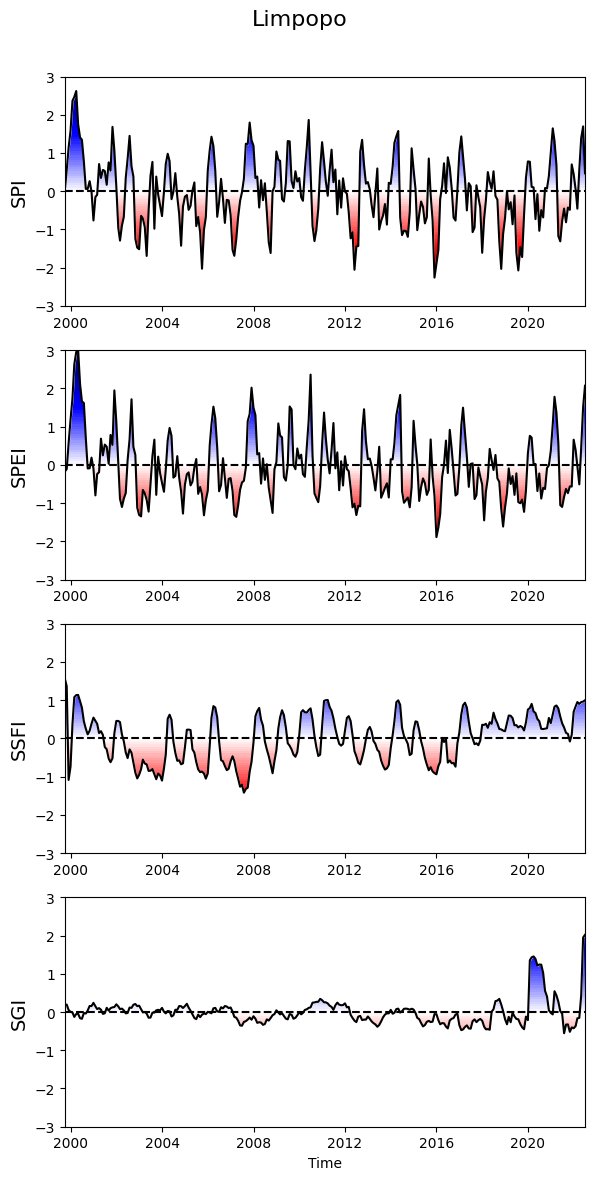

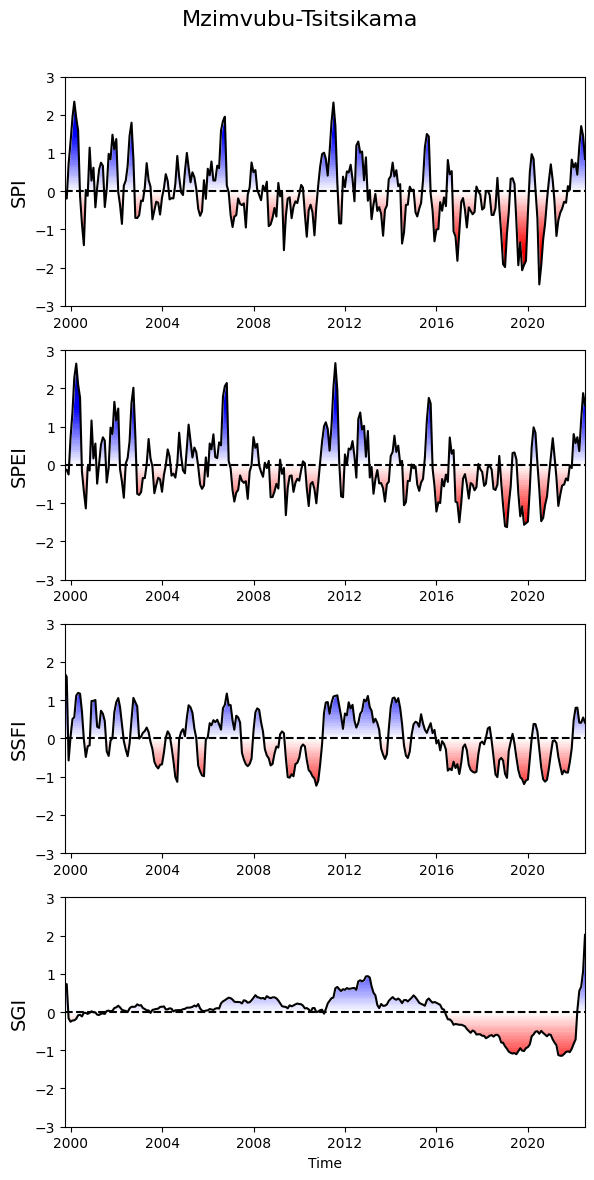

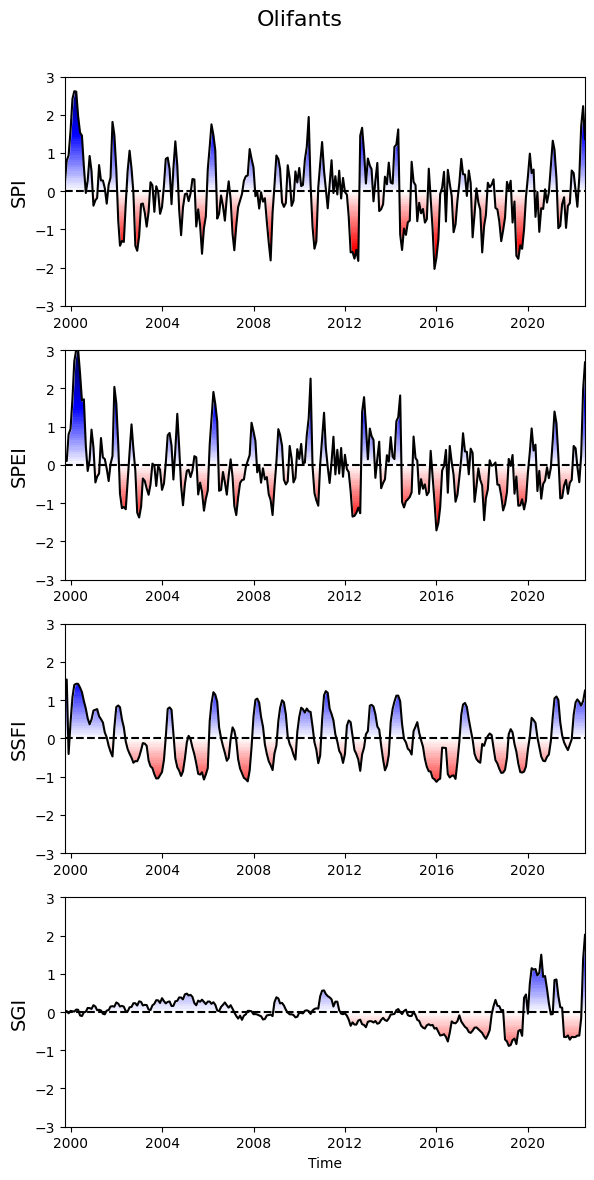

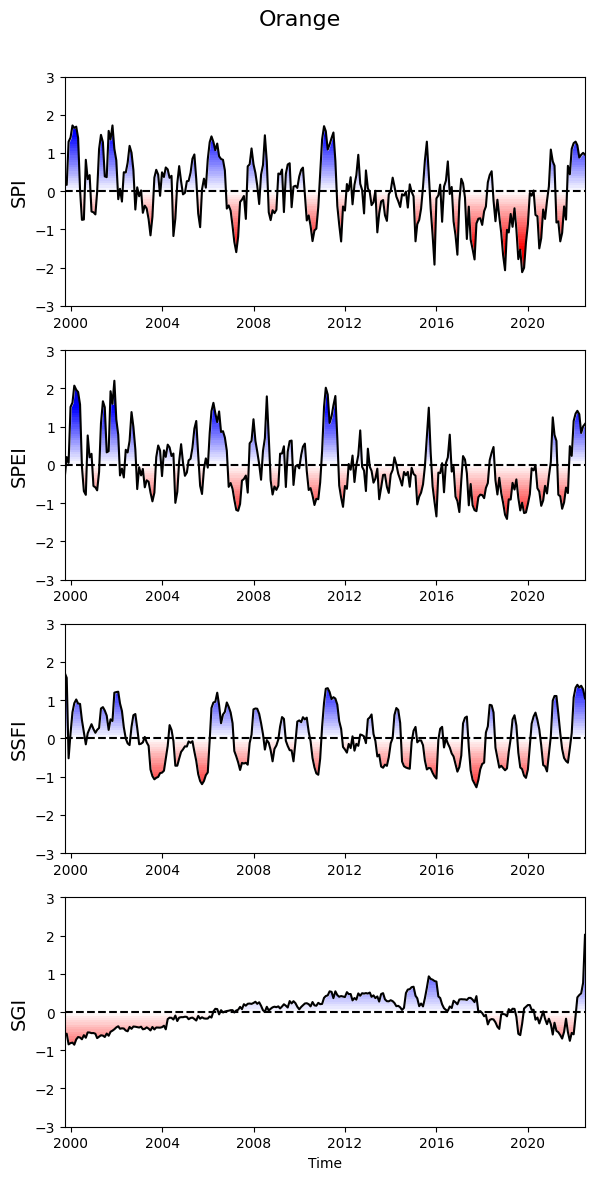

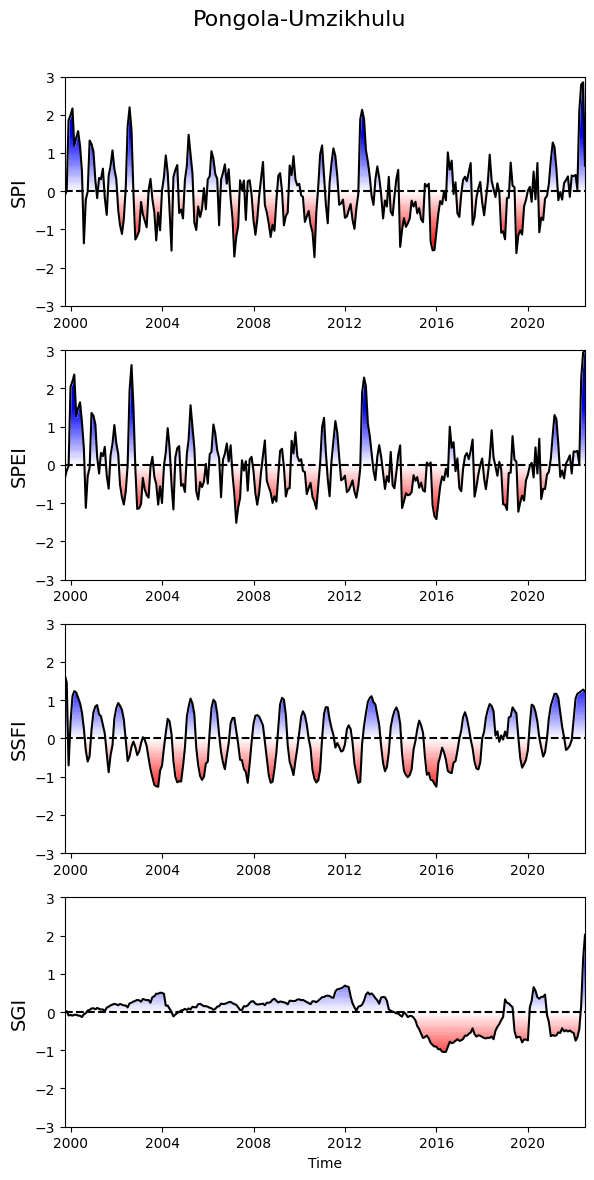

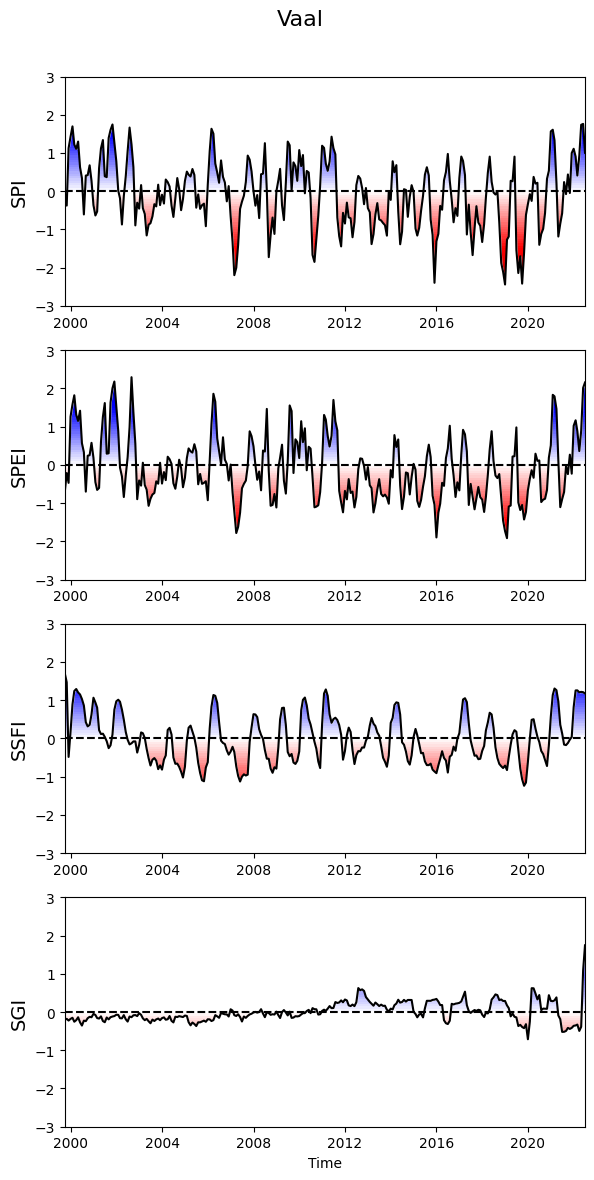

In [29]:
import spei as si 

# Get the list of area names 
area_names = sgi_averages.index.tolist()

# Create a figure and subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(6, 12))

# Iterate over each area
for areas in area_names:

    # Create a figure and subplots
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(6, 12))

    # Get the corresponding row from each dataframe
    row1 = df_spi.loc[areas]
    ts1 = pd.Series(row1.values, index=dates)
    row2 = df_spei.loc[areas]
    ts2 = pd.Series(row2.values, index=dates)
    row3 = sgi_averages.loc[areas]
    ts3 = pd.Series(row3.values, index=dates)
    row4 = ssfi_averages.loc[areas]
    ts4 = pd.Series(row4.values, index=dates)
    
    # Plot the data for each dataframe in a subplot
    si.plot.si(ts1, ax = axes[0])
    plt.xlabel("Time")
    plt.ylabel("SPI")
    
    si.plot.si(ts2, ax = axes[1])
    plt.xlabel("Time")
    plt.ylabel("SPEI")
    
    si.plot.si(ts3, ax = axes[3])
    plt.xlabel("Time")
    plt.ylabel("SGI")

    si.plot.si(ts4, ax = axes[2])
    plt.xlabel("Time")
    plt.ylabel("SSFI")

    # Add labels and adjust spacing
    fig.suptitle(areas, fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust the spacing between subplots

    [axes[i].set_ylabel(n, fontsize=14) for i, n in enumerate(["SPI", "SPEI","SSFI","SGI"])];

    # Show the plot
    plt.savefig(f'//gmvstorage.gmv.es/storage/anin/IndexComparison/EcoRegions/{areas}.png')

